# Подготовка обучающей выборки

In [ ]:
import pandas as pd
import json
import pickle
import numpy as np
from colour import Color
from collections import Counter
import nltk
import datetime as dt
import artm
import seaborn as sns

from pymystem3 import Mystem

%pylab inline

In [0]:
with open('dict_features.pkl', 'rb') as r:
    txt = r.read()
    feature_dict = pickle.loads(txt)

### Файл stories_description.csv (контент всех stories)

#### Извлечение информации из JSON

In [0]:
stories = pd.read_csv('stories_description.csv')
stories.head()

,story_id,story_json
0,127,"{""guid"":""770a5bae-0e3f-4a6b-b924-bd87bd51a038""..."
1,254,"{""guid"":""64f4c9ef-647b-4e04-b4d4-02297e939388""..."
2,865,"{""guid"":""3482206b-d223-4aec-92ba-0150055cd68a""..."
3,1491,"{""guid"":""5f4a9215-01de-4777-b70f-a18899db8f1c""..."
4,598,"{""guid"":""ed8754bd-67be-4fa1-9289-5508d96f1fa4""..."


In [0]:
def get_story_length(story):
    story_json = json.loads(story.replace('\\\\', '\\'))
    return len(list(filter(lambda x: x["type"] == 'story-page', story_json['content'])))


def get_recursively(search_dict, field):
    fields_found = []

    for key, value in search_dict.items():

        if key == field:
            fields_found.append(value)

        elif isinstance(value, dict):
            results = get_recursively(value, field)
            for result in results:
                fields_found.append(result)

        elif isinstance(value, list):
            for item in value:
                if isinstance(item, dict):
                    more_results = get_recursively(item, field)
                    for another_result in more_results:
                        fields_found.append(another_result)

    return fields_found
  

def get_text(story):
    story_json = json.loads(story.replace('\\\\', '\\'))
    res = []
    name = story_json.get('properties').get('name')
    if name:
        res.append(name)
    for page in list(filter(lambda x: x["type"] == 'story-page', story_json.get('content'))):
        res += get_recursively(page, 'text')
    if len(res):
        return ' '.join([sent.replace('\xa0', ' ') for sent in res]).replace('\n', ' ').replace('. ', ' ').replace(', ', ' ')
    return None

In [0]:
stories['length'] = stories['story_json'].apply(get_story_length)
stories['pure_text'] = stories['story_json'].apply(get_text)
stories.head()

,story_id,story_json,length,pure_text
0,127,"{""guid"":""770a5bae-0e3f-4a6b-b924-bd87bd51a038""...",5,Изменить пин-код Как изменить ПИН-код Зайдите ...
1,254,"{""guid"":""64f4c9ef-647b-4e04-b4d4-02297e939388""...",4,Пополнить «Стрелку» Как пополнить карту «Стрел...
2,865,"{""guid"":""3482206b-d223-4aec-92ba-0150055cd68a""...",8,Тинькофф Инвестиции 2.0 Тинькофф Инвестиции 2....
3,1491,"{""guid"":""5f4a9215-01de-4777-b70f-a18899db8f1c""...",8,Что делать на Faces & Laces Выставка уличной к...
4,598,"{""guid"":""ed8754bd-67be-4fa1-9289-5508d96f1fa4""...",6,Необычные виды спорта Необычные виды спорта Ес...


In [0]:
def get_colors(story):
    story_json = json.loads(story.replace('\\\\', '\\'))
    res = []
    res += get_recursively(story_json, 'hex')
    if len(res):
        return ' '.join(res)
    return None

In [0]:
stories['colors'] = stories['story_json'].apply(get_colors)
stories_preprocessed = stories.drop(columns=['story_json'])
stories_preprocessed.head()

,story_id,length,pure_text,colors
0,127,5,Изменить пин-код Как изменить ПИН-код Зайдите ...,#b8a1e0 #00bee0 #b8a1e0 #00bee0 #ffffff #fffff...
1,254,4,Пополнить «Стрелку» Как пополнить карту «Стрел...,#b8a1e0 #00bee0 #b8a1e0 #00bee0 #ffffff #fffff...
2,865,8,Тинькофф Инвестиции 2.0 Тинькофф Инвестиции 2....,#000000 #000000 #000000 #000000 #000000 #00000...
3,1491,8,Что делать на Faces & Laces Выставка уличной к...,#000000 #000000 #000000 #000000 #000000 #00000...
4,598,6,Необычные виды спорта Необычные виды спорта Ес...,#000000 #000000 #000000 #000000 #000000 #fffff...


#### Тематическое моделирование

Лемматизация текста:

In [0]:
mystem = Mystem()

def lemmatizate(pure_text):
    lemmas = mystem.lemmatize(pure_text)
    return [lemma for lemma in lemmas if lemma.isalpha()]

In [0]:
from tqdm import tqdm_notebook as tqdm

result = []

with tqdm(total=stories.shape[0]) as pbar:
    for text in stories.pure_text.values:
        result.append(lemmatizate(text))
        pbar.update(1)

In [0]:
stories_preprocessed['cleaned_text'] = np.array(result)

In [0]:
vowbal_wabbit = []
for (index, value) in zip(stories_preprocessed.index, stories_preprocessed.cleaned_text.values):
    vowbal_wabbit.append('{} |text {}{}'.format(index," ".join(value),'\n'))

Обучение модели BigARTM на полученных лемах. Выбранные 14 тем были получены экспериментальным подходом (перебирались количества тем от 10 до 30 и искались те модели, где было наименьшее число историй с одной "мусорной" темой):

Количество тем: 14
844.42224


Text(105.0, 0.5, 'Theme')

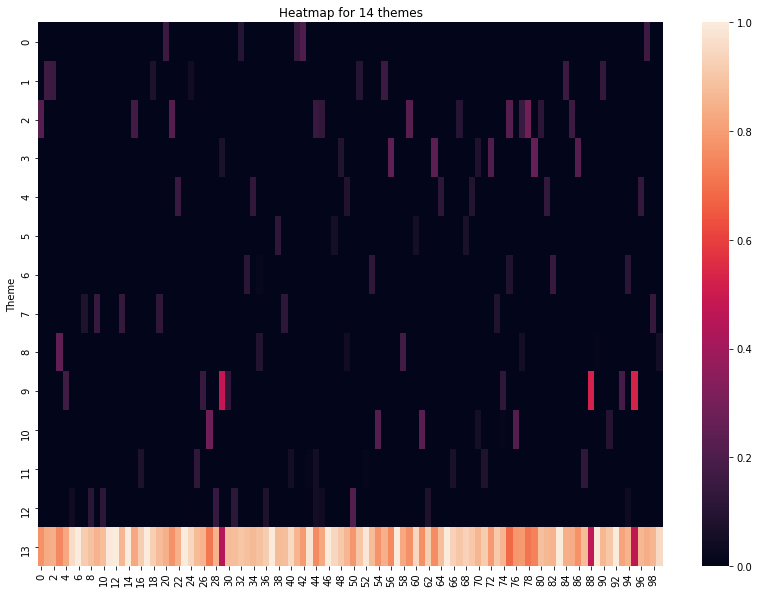

In [0]:
T = 14
BATCH_FOLDER = "stories_batches"
batch_vectorizer = artm.BatchVectorizer(data_path="vowbal_wabbit_stories.txt", data_format="vowpal_wabbit", 
                                        target_folder=BATCH_FOLDER, batch_size=100)
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]


model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1})
dictionary = artm.Dictionary()
dictionary.gather(data_path=BATCH_FOLDER)
model_artm.seed = 1
model_artm.initialize(dictionary=dictionary)
model_artm.cache_theta = True

model_artm.scores.add(artm.TopTokensScore(name="top_words_text", num_tokens=15, class_id="text"))
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name="SmoothPhi", 
                                                            tau=1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids={"text":1}, 
                                                            topic_names="bcg"))
model_artm.fit_offline(num_collection_passes=30, batch_vectorizer=batch_vectorizer)

model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name="SparsePhi", 
                                                            tau=-1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids={"text":1}, 
                                                            topic_names=topic_names[:-1]))
model_artm.fit_offline(num_collection_passes=15, batch_vectorizer=batch_vectorizer)

print('Количество тем: {}'.format(T))
theta = model_artm.get_theta()
theta_arr = theta.to_numpy()
print(np.sum(theta_arr[-1,:]))
fig, axes = plt.subplots(1, 1, figsize=(T, 10), sharey=True)
sns.heatmap(theta_arr[:,:100].reshape((T,100)));
axes.set_title("Heatmap for {} themes".format(T))
plt.ylabel('Theme')

In [0]:
theta = model_artm.get_theta()
stories_themes = pd.DataFrame(theta.to_numpy().T, columns=topic_names)
stories_themes.head()

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,sbj10,sbj11,sbj12,bcg
0,0.0,0.000000,0.223011,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.776989
1,0.0,0.167564,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.832436
2,0.0,0.153474,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.846526
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.247015,0.000000,0.0,0.0,0.0,0.752985
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.169333,0.0,0.0,0.0,0.830667


#### Обработка цветовой гаммы

После нахождения массива цветов, используемых в историях, кодируем их в отдельные цветовые оттенки (используем цветовую модель HSL), а потом отбираем первые два цвета по популярности:

In [0]:
color_bins = np.array([0, 45, 90, 135, 165, 195, 225, 270, 300, 345])
color_bins = color_bins/360
color_labels = ['Red', 'Yellow', 'Green', 'Cyan', 'Blue', 'Dark blue', 'Violet', 'Pink', 'Red']

def choose_primary_color(colors):
    color_labels = []
    for color in colors.split(' '):
        color_labels.append(color_pick(color))
        
    color_array = np.array(color_labels)
    
    counter = Counter(color_array[color_array != 'NI'])
    if len(counter) == 0:
        return 'NI'
    return counter.most_common(1)[0][0]

def color_pick(colour, alpha=0.1):
    c = Color(colour)
    if c.get_luminance() > 1-alpha or c.get_luminance() < alpha or \
    c.get_saturation() < alpha:
        return "NI" #Not Interested
    hue = c.get_hue()
    for i in np.arange(len(color_bins)):
        if hue < color_bins[i]:
            return color_labels[i-1]
    return 'Red'

def choose_secondary_color(colors):
    color_labels = []
    for color in colors.split(' '):
        color_labels.append(color_pick(color))
        
    color_array = np.array(color_labels)
    
    counter = Counter(color_array[color_array != 'NI'])
    if len(counter) < 2:
        return 'NI'
    return counter.most_common(2)[1][0]


In [0]:
exclude_features = ['pure_text', 'colors', 'story_json']
stories_preprocessed['primary_color'] = stories_preprocessed.colors.apply(choose_primary_color)
stories_preprocessed['secondary_color'] = stories_preprocessed.colors.apply(choose_secondary_color)

stories_preprocessed.head()

,story_id,length,pure_text,colors,cleaned_text,primary_color,secondary_color
0,127,5,Изменить пин-код Как изменить ПИН-код Зайдите ...,#b8a1e0 #00bee0 #b8a1e0 #00bee0 #ffffff #fffff...,"[изменять, пин, код, как, изменять, пин, код, ...",Violet,Blue
1,254,4,Пополнить «Стрелку» Как пополнить карту «Стрел...,#b8a1e0 #00bee0 #b8a1e0 #00bee0 #ffffff #fffff...,"[пополнять, стрелка, как, пополнять, карта, ст...",Violet,Blue
2,865,8,Тинькофф Инвестиции 2.0 Тинькофф Инвестиции 2....,#000000 #000000 #000000 #000000 #000000 #00000...,"[тинькофф, инвестиция, тинькофф, инвестиция, у...",Yellow,NI
3,1491,8,Что делать на Faces & Laces Выставка уличной к...,#000000 #000000 #000000 #000000 #000000 #00000...,"[что, делать, на, Faces, Laces, выставка, улич...",NI,NI
4,598,6,Необычные виды спорта Необычные виды спорта Ес...,#000000 #000000 #000000 #000000 #000000 #fffff...,"[необычный, вид, спорт, необычный, вид, спорт,...",Yellow,NI


In [0]:
primary_color_ohe = pd.get_dummies(stories_preprocessed.primary_color).add_prefix('primary_')
secondary_color_ohe = pd.get_dummies(stories_preprocessed.secondary_color).add_prefix('secondary_')

colors_ohe = pd.merge(primary_color_ohe, secondary_color_ohe, left_index=True, right_index=True)
stories_colors = stories.join(colors_ohe).drop(columns=exclude_features)
stories_complete = stories_colors.join(stories_themes)

stories_complete.columns

Index(['story_id', 'length', 'primary_Blue', 'primary_Dark blue',
       'primary_Green', 'primary_NI', 'primary_Red', 'primary_Violet',
       'primary_Yellow', 'secondary_Blue', 'secondary_Cyan',
       'secondary_Dark blue', 'secondary_Green', 'secondary_NI',
       'secondary_Pink', 'secondary_Red', 'secondary_Violet',
       'secondary_Yellow', 'sbj0', 'sbj1', 'sbj2', 'sbj3', 'sbj4', 'sbj5',
       'sbj6', 'sbj7', 'sbj8', 'sbj9', 'sbj10', 'sbj11', 'sbj12', 'bcg'],
      dtype='object')

In [0]:
stories_complete.to_csv('stories_preprocessed.csv', index=False)

### Файл transactions.csv (транзакции пользователей за 3 месяца)

In [0]:
data = pd.read_csv('cleaned_transactions.csv')
data.head()

,customer_id,transaction_month,transaction_day,transaction_amt,merchant_id,merchant_mcc,mcc_group
0,855115,7,3,1500,4554547,5411,Розничные магазины
1,997036,6,6,0,1657528,5411,Розничные магазины
2,398237,5,24,2500,26375569,5813,Различные магазины
3,997036,6,2,0,16304402,5411,Розничные магазины
4,291636,7,25,0,1259505,5411,Розничные магазины


Были взяты исходные MCC-коды с сайта (https://mcc-codes.ru/code) и использованы в таблице для получения групп магазинов.

In [0]:
mcc_codes = pd.read_excel("MCC_codes.xlsx", index_col ='mcc')
mcc = mcc_codes.group.to_dict()
data['mcc_group'] = data['merchant_mcc'].map(mcc)

C:\Users\Nikita\Anaconda3\lib\site-packages\defusedxml\ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)


In [0]:
data_amt = data.groupby('mcc_group').transform(lambda x: x / x.max())
data['transaction_normalized'] = data_amt['transaction_amt']
data.drop(columns=['transaction_amt'], inplace=True)
data.head()

,customer_id,transaction_month,transaction_day,merchant_id,merchant_mcc,mcc_group,transaction_normalized
0,855115,7,3,4554547,5411,Розничные магазины,0.004348
1,997036,6,6,1657528,5411,Розничные магазины,0.000000
2,398237,5,24,26375569,5813,Различные магазины,0.002019
3,997036,6,2,16304402,5411,Розничные магазины,0.000000
4,291636,7,25,1259505,5411,Розничные магазины,0.000000


In [0]:
sparse_transactions = pd.pivot_table(data, values='transaction_normalized', index=['customer_id'], aggfunc='sum',
                     columns=['mcc_group'], fill_value = 0).add_suffix('_amt')
sparse_transactions.head()

mcc_group,"Авиалинии, авиакомпании_amt",Автомобили и транспортные средства_amt,Аренда автомобилей_amt,Бизнес услуги_amt,Государственные услуги_amt,Коммунальные и кабельные услуги_amt,Контрактные услуги_amt,Личные услуги_amt,Магазины одежды_amt,Оптовые поставщики и производители_amt,Отели и мотели_amt,Поставщик услуг_amt,Продажи по почте/ телефону_amt,Профессиональные услуги_amt,Развлечения_amt,Различные магазины_amt,Ремонтные услуги_amt,Розничные магазины_amt,Транспорт_amt,Членские организации_amt
customer_id,,,,,,,,,,,,,,,,,,,,
15,1.448833,0.000000,0.000000,0.000000,0.000000,0.007342,0.0,0.026471,0.717172,0.0,0.859102,0.000000,0.0,0.000000,0.105691,0.144126,0.014514,0.501449,0.028681,0.000000
73,0.082585,0.015546,0.178439,0.011364,0.045891,0.041116,0.0,0.035294,0.177489,0.0,0.411471,0.249711,0.0,0.004853,0.193767,0.218409,0.000000,0.224638,0.431166,0.031579
91,0.001197,0.041597,0.000000,0.000000,0.004269,0.005874,0.0,0.000000,0.000000,0.0,0.089776,0.005780,0.0,0.000000,0.008130,0.075495,0.000000,0.437681,0.142447,0.000000
144,0.000000,0.001261,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.002826,0.000000,0.000000,0.000000,0.000000
150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [0]:
sparse_transactions.to_csv('preprocessed_transactions.csv', index=True)

### Файлы "customer_train.csv" и "customer_train.csv"

In [0]:
users_train = pd.read_csv("customer_train.csv")
users_test = pd.read_csv("customer_test.csv")

In [0]:
users_train.isna().sum()

customer_id               0
product_0             48401
product_1             26275
product_2             45609
product_3             43187
product_4             47818
product_5             16574
product_6             47646
gender_cd               363
age                     310
marital_status_cd     18793
children_cnt           5271
first_session_dttm        3
job_position_cd           0
job_title             23503
dtype: int64

In [0]:
users_train_cleaned = users_train.dropna(subset=['gender_cd', 'age', 'first_session_dttm'])

In [ ]:
users_train_cleaned['children_cnt_na'] = users_train_cleaned.children_cnt.isna()
users_train_cleaned.children_cnt.fillna(-1, inplace=True)
users_train_cleaned.marital_status_cd.fillna('unknown', inplace=True)
product_features = ["product_{}".format(i) for i in range(7)]
users_train_cleaned.drop(columns=product_features, inplace=True)
users_train_cleaned.drop(columns=['job_title'], inplace=True)

users_test['children_cnt_na'] = users_test.children_cnt.isna()
users_test.children_cnt.fillna(-1, inplace=True)
users_test.marital_status_cd.fillna('unknown', inplace=True)
users_test.drop(columns=product_features, inplace=True)    
users_test.drop(columns=['job_title'], inplace=True)

In [0]:
users_g_train = users_train_cleaned.join(pd.get_dummies(users_train_cleaned.gender_cd).add_prefix('g_'))
users_g_train = users_g_train.drop(columns=['gender_cd'])

users_gm_train = users_g_train.join(pd.get_dummies(users_g_train.marital_status_cd).add_prefix('m_'))
users_gm_train = users_gm_train.drop(columns=['marital_status_cd'])

users_gmj_train = users_gm_train.join(pd.get_dummies(users_gm_train.job_position_cd).add_prefix('j_'))
users_gmj_train = users_gmj_train.drop(columns=['job_position_cd'])

users_gmj_train['children_cnt_na'] = users_gmj_train['children_cnt_na'].astype('int')

In [0]:
users_g_test = users_test.join(pd.get_dummies(users_test.gender_cd).add_prefix('g_'))
users_g_test = users_g_test.drop(columns=['gender_cd'])

users_gm_test = users_g_test.join(pd.get_dummies(users_g_test.marital_status_cd).add_prefix('m_'))
users_gm_test = users_gm_test.drop(columns=['marital_status_cd'])

users_gmj_test = users_gm_test.join(pd.get_dummies(users_gm_test.job_position_cd).add_prefix('j_'))
users_gmj_test = users_gmj_test.drop(columns=['job_position_cd'])

users_gmj_test['children_cnt_na'] = users_gmj_test['children_cnt_na'].astype('int')

In [0]:
users_gmj_train.to_csv('fin_customers_train.csv', index=False)
users_gmj_test.to_csv('fin_customers_test.csv', index=False)

### Объединение всех таблиц в один датасет

In [0]:
users_test = pd.read_csv('fin_customers_test.csv')
users_train = pd.read_csv('fin_customers_train.csv')

transactions = pd.read_csv('preprocessed_transactions.csv')
stories = pd.read_csv('stories_preprocessed.csv')

reactions_train = pd.read_csv('stories_reaction_train.csv')
reactions_test = pd.read_csv('stories_reaction_test.csv')

In [0]:
joined_train = pd.merge(users_train, 
                  transactions,
                  on='customer_id',
                  how='left')
joined_train.loc[:, feature_dict['transactions_amt']] = joined_train.loc[:, feature_dict['transactions_amt']].fillna(0)


joined_test = pd.merge(users_test, 
                  transactions,
                  on='customer_id',
                  how='left')
joined_test.loc[:, feature_dict['transactions_amt']] = joined_test.loc[:, feature_dict['transactions_amt']].fillna(0)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
joined_test[['age']] = imp.fit_transform(joined_test[['age']])

In [0]:
joined_test.head()

,customer_id,age,children_cnt,first_session_dttm,children_cnt_na,g_F,g_M,m_CIV,m_DIV,m_DLW,...,Отели и мотели_amt,Поставщик услуг_amt,Продажи по почте/ телефону_amt,Профессиональные услуги_amt,Развлечения_amt,Различные магазины_amt,Ремонтные услуги_amt,Розничные магазины_amt,Транспорт_amt,Членские организации_amt
0,234305,25.0,0.0,2015-10-29 09:59:10,0,1,0,0,0,0,...,0.000000,0.0,0.0,0.016446,0.010840,0.180057,0.0,0.249275,0.049713,0.0
1,914339,15.0,0.0,2018-04-09 08:51:54,0,0,1,0,0,0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000807,0.0,0.002899,0.002868,0.0
2,895631,20.0,0.0,2018-03-22 10:38:33,0,0,1,0,0,0,...,0.000000,0.0,0.0,0.000000,0.002710,0.015745,0.0,0.110145,0.000000,0.0
3,954837,25.0,0.0,2018-05-09 18:24:32,0,1,0,0,0,0,...,0.021197,0.0,0.0,0.000000,0.006775,0.031490,0.0,0.049275,0.021989,0.0
4,391590,30.0,0.0,2016-10-08 05:29:20,0,0,1,0,0,0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [0]:
stories_with_reactions_train = pd.merge(stories, reactions_train, on='story_id', how='inner')
stories_with_reactions_test = pd.merge(stories, reactions_test, on='story_id', how='right')

final_train = pd.merge(joined_train, stories_with_reactions_train, on='customer_id', how='inner')
final_test = pd.merge(joined_test, stories_with_reactions_test, on='customer_id', how='right')

### Финальная дообработка

In [0]:
final_test.loc[final_test['first_session_dttm'].isna(), 
               ['first_session_dttm']] = final_test.loc[final_test['first_session_dttm'].isna()]['event_dttm']

In [0]:
final_train.fillna(0, inplace=True)
final_test.fillna(0, inplace=True)

Получение временных характеристик показа истории (время суток, день недели, какое количество дней прошло с регистрации пользователя в приложении):

In [0]:
fmt = '%Y-%m-%d %H:%M:%S'
final_train['event_dttm'] = final_train['event_dttm'].apply(lambda x: dt.datetime.strptime(x, fmt))
final_train['first_session_dttm'] = final_train['first_session_dttm'].apply(lambda x: dt.datetime.strptime(x, fmt))
final_train['days_in_app'] = (final_train['event_dttm'] - final_train['first_session_dttm'])/np.timedelta64(1,'D')

final_train['hour'] = final_train['event_dttm'].apply(lambda x: x.hour)
final_train['morning'] = ((final_train['hour'] >= 7) & (final_train['hour'] <= 11)).astype('int')
final_train['day'] = ((final_train['hour'] >= 12) & (final_train['hour'] <= 17)).astype('int')
final_train['evening'] = ((final_train['hour'] >= 18) & (final_train['hour'] <= 23)).astype('int')
final_train['night'] = ((final_train['hour'] >= 0) & (final_train['hour'] <= 6)).astype('int')

final_train['day_of_week'] = final_train['event_dttm'].apply(lambda x: x.weekday())
final_train['monday'] = (final_train['day_of_week'] == 0).astype('int')
final_train['tuesday'] = (final_train['day_of_week'] == 1).astype('int')
final_train['wednesday'] = (final_train['day_of_week'] == 2).astype('int')
final_train['thursday'] = (final_train['day_of_week'] == 3).astype('int')
final_train['friday'] = (final_train['day_of_week'] == 4).astype('int')
final_train['saturday'] = (final_train['day_of_week'] == 5).astype('int')
final_train['sunday'] = (final_train['day_of_week'] == 6).astype('int')

In [0]:
fmt = '%Y-%m-%d %H:%M:%S'
final_test['event_dttm'] = final_test['event_dttm'].apply(lambda x: dt.datetime.strptime(x, fmt))
final_test['first_session_dttm'] = final_test['first_session_dttm'].apply(lambda x: dt.datetime.strptime(x, fmt))
final_test['days_in_app'] = (final_test['event_dttm'] - final_test['first_session_dttm'])/np.timedelta64(1,'D')

final_test['hour'] = final_test['event_dttm'].apply(lambda x: x.hour)
final_test['morning'] = ((final_test['hour'] >= 7) & (final_test['hour'] <= 11)).astype('int')
final_test['day'] = ((final_test['hour'] >= 12) & (final_test['hour'] <= 17)).astype('int')
final_test['evening'] = ((final_test['hour'] >= 18) & (final_test['hour'] <= 23)).astype('int')
final_test['night'] = ((final_test['hour'] >= 0) & (final_test['hour'] <= 6)).astype('int')

final_test['day_of_week'] = final_test['event_dttm'].apply(lambda x: x.weekday())
final_test['monday'] = (final_test['day_of_week'] == 0).astype('int')
final_test['tuesday'] = (final_test['day_of_week'] == 1).astype('int')
final_test['wednesday'] = (final_test['day_of_week'] == 2).astype('int')
final_test['thursday'] = (final_test['day_of_week'] == 3).astype('int')
final_test['friday'] = (final_test['day_of_week'] == 4).astype('int')
final_test['saturday'] = (final_test['day_of_week'] == 5).astype('int')
final_test['sunday'] = (final_test['day_of_week'] == 6).astype('int')

In [0]:
columns=['event_dttm', 'first_session_dttm', 'customer_id', 
         'story_id', 'j_5', 'secondary_Dark blue', 'bcg',
         'hour', 'day_of_week']
final_train.drop(columns=columns, inplace=True)
final_test.drop(columns=columns, inplace=True)

In [0]:
final_train.shape, final_test.shape

((431986, 93), (172049, 93))

In [0]:
final_train.to_csv('final_train.csv', index=False)
final_test.to_csv('final_test.csv', index=False)